In [1]:
!wget https://www.dropbox.com/s/tcwbjzghs1xu8vv/ratings.csv

--2020-06-16 10:03:09--  https://www.dropbox.com/s/tcwbjzghs1xu8vv/ratings.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/tcwbjzghs1xu8vv/ratings.csv [following]
--2020-06-16 10:03:09--  https://www.dropbox.com/s/raw/tcwbjzghs1xu8vv/ratings.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3733dbbc2809edfe61a7fa9bc9.dl.dropboxusercontent.com/cd/0/inline/A5xiHfLsCYxMW5NlEqvh2uKW8tSyx78UXGVuDW3dmkanS-r8lqfhhb0lBy29akeTpceS7Cmf1ko4IORYwsH1i3aTux-pbxjKmA7T9V2yPIqcXVRlu21HDg-BKyDnATjgZs0/file# [following]
--2020-06-16 10:03:10--  https://uc3733dbbc2809edfe61a7fa9bc9.dl.dropboxusercontent.com/cd/0/inline/A5xiHfLsCYxMW5NlEqvh2uKW8tSyx78UXGVuDW3dmkanS-r8lqfhhb0lBy29akeTpceS7Cmf1ko4IORYwsH1i3aTux-pbxjKmA7T9V2yPIqcXVRlu2

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
!pip install emoji text-cleaner keras sklearn pandas numpy seaborn

     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=e7c0692a0769c43c7a961d3a7e08395ad8573a2f3a3c1573c20ff438234998df
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [4]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.zh.vec

--2020-06-16 10:03:42--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.zh.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 861327482 (821M) [binary/octet-stream]
Saving to: ‘wiki.zh.vec’

wiki.zh.vec         100%[===================>] 821.43M  12.2MB/s    in 69s     

2020-06-16 10:04:52 (11.9 MB/s) - ‘wiki.zh.vec’ saved [861327482/861327482]



In [5]:
import pandas as pd
import numpy as np
import re
import emoji

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from text_cleaner import remove
from text_cleaner.processor.chinese import CHINESE, CHINESE_SYMBOLS_AND_PUNCTUATION
from text_cleaner import remove
from text_cleaner.processor.common import ASCII, SYMBOLS_AND_PUNCTUATION_EXTENSION, GENERAL_PUNCTUATION
import seaborn as sns

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
movie_reviews = pd.read_csv("ratings.csv")

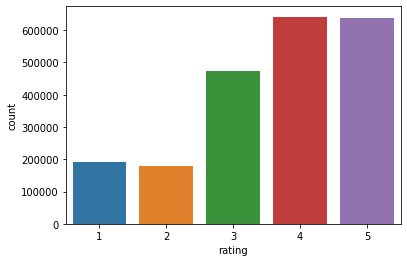

In [7]:
sns.countplot(x='rating', data=movie_reviews)

In [0]:
def escape_emoji(text):
    emoji_pattern = re.compile(
        u'(\U0001F1F2\U0001F1F4)|'       # Macau flag
        u'([\U0001F1E6-\U0001F1FF]{2})|' # flags
        u'([\U0001F600-\U0001F64F])'     # emoticons
        "+", flags=re.UNICODE)
    return emoji_pattern.sub('', text)


def escape_en_char(string):
    en_pattern = "[a-zA-Z0-9]+"
    one_str = re.sub(en_pattern, ' ', string)
    return one_str

def remove_pun(string):
    s = SYMBOLS_AND_PUNCTUATION_EXTENSION.remove(string)
    s = GENERAL_PUNCTUATION.remove(string)
    s = CHINESE_SYMBOLS_AND_PUNCTUATION.remove(string)
    return s

In [0]:
def preprocess_text(sens):
    sentence = escape_en_char(sens)
    sentence = escape_emoji(sens)
    sentence = remove_pun(sens)
    sentence = ' '.join(sentence.split())
    return sentence

In [0]:
movie_reviews['comment'] = movie_reviews['comment'].apply(preprocess_text)

In [0]:
x_real = movie_reviews['comment']
y_real = movie_reviews['rating'].values

In [0]:
x_train_real,x_test_real,y_train_real, y_test_real = train_test_split(x_real,y_real, test_size=0.30, random_state=42)

In [0]:
y = pd.get_dummies(movie_reviews['rating']).values
y = np.array(list(map(lambda x: x , y)))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(movie_reviews['comment'], y, test_size=0.30, random_state=42)

In [0]:
tokenizer = Tokenizer(char_level = True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(X_train)

In [0]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [0]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [0]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
skipgram_file = open('wiki.zh.vec', encoding="utf8")

for line in skipgram_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
skipgram_file.close()

In [0]:
embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [0]:
from keras.layers import Conv1D,MaxPooling1D,Bidirectional

# LSTM Model for Multi-Class

In [0]:
from keras.layers import CuDNNLSTM

In [22]:
model_rnn = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model_rnn.add(embedding_layer)
model_rnn.add(CuDNNLSTM(100))
model_rnn.add(Dense(100,activation='relu'))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(5, activation='softmax'))
model_rnn.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [23]:
model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          2669700   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100)               160800    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 2,841,105
Trainable params: 171,405
Non-trainable params: 2,669,700
_________________________________________________________________


In [24]:
history_b = model_rnn.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.4)


Train on 892523 samples, validate on 595016 samples
Epoch 1/15
892523/892523 [==============================] - 243s 272us/step - loss: 1.4828 - acc: 0.3069 - val_loss: 1.4859 - val_acc: 0.3027
Epoch 2/15
892523/892523 [==============================] - 238s 266us/step - loss: 1.4116 - acc: 0.3408 - val_loss: 1.3380 - val_acc: 0.3878
Epoch 3/15
892523/892523 [==============================] - 237s 265us/step - loss: 1.3249 - acc: 0.3971 - val_loss: 1.2780 - val_acc: 0.4225
Epoch 4/15
892523/892523 [==============================] - 236s 264us/step - loss: 1.2751 - acc: 0.4263 - val_loss: 1.2481 - val_acc: 0.4348
Epoch 5/15
892523/892523 [==============================] - 236s 265us/step - loss: 1.2329 - acc: 0.4501 - val_loss: 1.1944 - val_acc: 0.4664
Epoch 6/15
892523/892523 [==============================] - 238s 267us/step - loss: 1.2104 - acc: 0.4650 - val_loss: 1.1771 - val_acc: 0.4764
Epoch 7/15
892523/892523 [==============================] - 237s 265us/step - loss: 1.1845 - ac

In [25]:
score_lstm, acc_lstm = model_rnn.evaluate(X_test, y_test,batch_size=128)

637517/637517 [==============================] - 57s 89us/step


In [26]:
print('LSTM Model score is:' ,score_lstm)
print('LSTM Model accuracy is:' ,acc_lstm)

LSTM Model score is: 1.1580454703786416
LSTM Model accuracy is: 0.4981059432029724


In [27]:
from sklearn.metrics import classification_report
Y_pred_rnn = model_rnn.predict_classes(X_test)
print(Y_pred_rnn)

[3 3 4 ... 3 3 3]


In [28]:
np.unique(Y_pred_rnn)

array([0, 1, 2, 3, 4])

In [0]:
Y_pred_rnn = list(map(lambda x: x+1 , Y_pred_rnn))

# Classification Metrics: LSTM Multi-Class Skip Gram

In [30]:
print('Training Dataset Size :',X_train.shape)
print('Testing Dataset Size :',X_test.shape)
classes = ['1','2','3','4','5']
print('Classification Report: LSTM Multi-Class Model Skip Gram\n',classification_report(y_test_real,Y_pred_rnn,target_names = classes ),'\n')

Training Dataset Size : (1487539, 100)
Testing Dataset Size : (637517, 100)
Classification Report: LSTM Multi-Class Model Skip Gram
               precision    recall  f1-score   support

           1       0.67      0.40      0.50     57306
           2       0.53      0.11      0.18     53867
           3       0.45      0.38      0.41    142306
           4       0.42      0.62      0.50    192429
           5       0.61      0.60      0.61    191609

    accuracy                           0.50    637517
   macro avg       0.54      0.42      0.44    637517
weighted avg       0.52      0.50      0.49    637517
 



In [0]:
y_test_real = y_test_real.tolist()

In [0]:
x_test_real = x_test_real.tolist()

In [0]:
predicted_data_rnn = pd.DataFrame([x_test_real, y_test_real , Y_pred_rnn])

In [0]:
predicted_data_rnn_t = predicted_data_rnn.T

In [35]:
predicted_data_rnn_t.head(50)

,0,1,2
0,为数不多的好看的喜剧,5,4
1,故事完成度很高 比起之前作品更接地气 剧情太好猜了点 不过总算完成了一个非短片,4,4
2,这世上最可怕的是人性,5,5
3,强烈推荐,5,5
4,杨幂不亏为烂片女王 黄晓明你让我在合伙人里对你的好感一点点磨没了 反正杨幂你现在给我的映像就...,1,1
5,已经上映了啊 我刚看完 开头套路有点无聊但场面很壮观 故事逻辑清晰 关键点都能交代清楚 总之...,4,4
6,后悔没去影院看,5,4
7,简直是 在挑战自己的忍耐底限 强迫症看了开头就一定要看完 简直如外星人般无法理解 这种东西的...,1,1
8,被鞋拔子脸的大圣帅一脸 QWQ 最后变身眼睛放光从耳朵里抽出金箍棒的场面简直是 简直是 Qw...,5,5
9,还是挺不错的,4,4


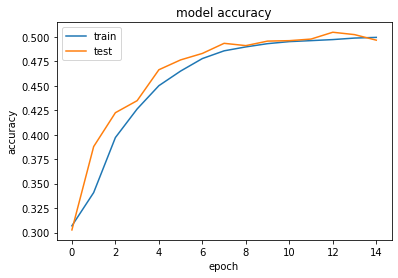

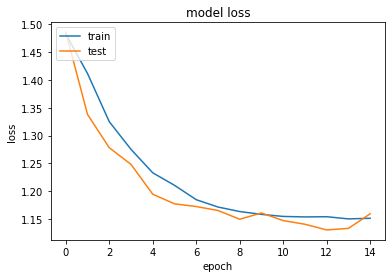

In [36]:
import matplotlib.pyplot as plt

plt.plot(history_b.history['acc'])
plt.plot(history_b.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history_b.history['loss'])
plt.plot(history_b.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# Bi-LSTM Model for Multi-Class

In [0]:
model_brnn = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model_brnn.add(embedding_layer)
model_brnn.add(Bidirectional(CuDNNLSTM(100)))
model_brnn.add(Dense(100,activation='relu'))
model_brnn.add(Dropout(0.5))
model_brnn.add(Dense(5, activation='softmax'))
model_brnn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [38]:
model_brnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          2669700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               321600    
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 505       
Total params: 3,011,905
Trainable params: 342,205
Non-trainable params: 2,669,700
_________________________________________________________________


In [39]:
history_c = model_brnn.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.3)

Train on 1041277 samples, validate on 446262 samples
Epoch 1/20
1041277/1041277 [==============================] - 491s 471us/step - loss: 1.3493 - acc: 0.3902 - val_loss: 1.2783 - val_acc: 0.4289
Epoch 2/20
1041277/1041277 [==============================] - 491s 471us/step - loss: 1.2219 - acc: 0.4597 - val_loss: 1.1827 - val_acc: 0.4744
Epoch 3/20
1041277/1041277 [==============================] - 495s 476us/step - loss: 1.1846 - acc: 0.4792 - val_loss: 1.1672 - val_acc: 0.4814
Epoch 4/20
1041277/1041277 [==============================] - 493s 474us/step - loss: 1.1707 - acc: 0.4870 - val_loss: 1.1493 - val_acc: 0.4943
Epoch 5/20
1041277/1041277 [==============================] - 494s 474us/step - loss: 1.1636 - acc: 0.4906 - val_loss: 1.1407 - val_acc: 0.4969
Epoch 6/20
1041277/1041277 [==============================] - 492s 472us/step - loss: 1.1613 - acc: 0.4934 - val_loss: 1.1423 - val_acc: 0.5021
Epoch 7/20
1041277/1041277 [==============================] - 491s 471us/step - los

In [40]:
score_bilstm, acc_bilstm = model_brnn.evaluate(X_test, y_test,batch_size=128)

637517/637517 [==============================] - 108s 169us/step


In [41]:
print('Bi-LSTM Model score is:' ,score_bilstm)
print('Bi-LSTM Model accuracy is:' ,acc_bilstm)

Bi-LSTM Model score is: 1.1471652318510352
Bi-LSTM Model accuracy is: 0.4994407892227173


In [42]:
from sklearn.metrics import classification_report
Y_pred_brnn = model_brnn.predict_classes(X_test)
print(Y_pred_brnn)

[3 3 4 ... 4 2 4]


In [43]:
np.unique(Y_pred_brnn)

array([0, 1, 2, 3, 4])

In [0]:
Y_pred_brnn = list(map(lambda x: x+1 , Y_pred_brnn))

# Classification Metrics: Bi-LSTM Multi-Class Skip Gram

In [45]:
print('Training Dataset Size :',X_train.shape)
print('Testing Dataset Size :',X_test.shape)
classes = ['1','2','3','4','5']
print('Classification Report: Bi-LSTM Multi-Class Model Skip Gram\n',classification_report(y_test_real,Y_pred_brnn,target_names = classes ),'\n')

Training Dataset Size : (1487539, 100)
Testing Dataset Size : (637517, 100)
Classification Report: Bi-LSTM Multi-Class Model Skip Gram
               precision    recall  f1-score   support

           1       0.50      0.59      0.54     57306
           2       0.67      0.07      0.12     53867
           3       0.47      0.41      0.43    142306
           4       0.45      0.41      0.43    192429
           5       0.54      0.75      0.63    191609

    accuracy                           0.50    637517
   macro avg       0.53      0.45      0.43    637517
weighted avg       0.51      0.50      0.48    637517
 



In [0]:
predicted_data_brnn = pd.DataFrame([x_test_real, y_test_real , Y_pred_brnn])

In [0]:
predicted_data_brnn_t = predicted_data_brnn.T

In [48]:
predicted_data_brnn_t.head()

,0,1,2
0,为数不多的好看的喜剧,5,4
1,故事完成度很高 比起之前作品更接地气 剧情太好猜了点 不过总算完成了一个非短片,4,4
2,这世上最可怕的是人性,5,5
3,强烈推荐,5,5
4,杨幂不亏为烂片女王 黄晓明你让我在合伙人里对你的好感一点点磨没了 反正杨幂你现在给我的映像就...,1,1


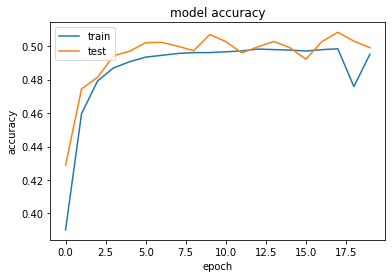

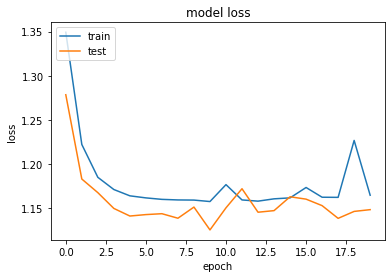

In [49]:
import matplotlib.pyplot as plt

plt.plot(history_c.history['acc'])
plt.plot(history_c.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history_c.history['loss'])
plt.plot(history_c.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

Parameters For Each Model:

1) CNN :
-->input_size/Input Layer = 100
-->activation = relu
-->Output/Dense Layer = 5 (Activation = Softmax)
-->Learning Rate = 0.001
-->Optimizer = Adam


2) LSTM :
-->input_size/Input Layer = 100
-->activation = relu
-->Dense Layer = 100
-->Dropout = 0.5
-->Output/Dense Layer = 5 (Activation = Softmax)
-->Learning Rate = 0.001
-->Optimizer = RMSProp


3) Bidirectional-LSTM :
-->input_size/Input Layer = 100
-->activation = relu
-->Dense Layer = 100
-->Dropout = 0.5
-->Output/Dense Layer = 5 (Activation = Softmax)
-->Learning Rate = 0.001
-->Optimizer = RMSProp